In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal

In [2]:
FS = 44100

In [3]:
_, audio_1 = scipy.io.wavfile.read("clapping_1.wav")
_, audio_2 = scipy.io.wavfile.read("clapping_2.wav")
audio = np.concatenate((audio_1, audio_2))

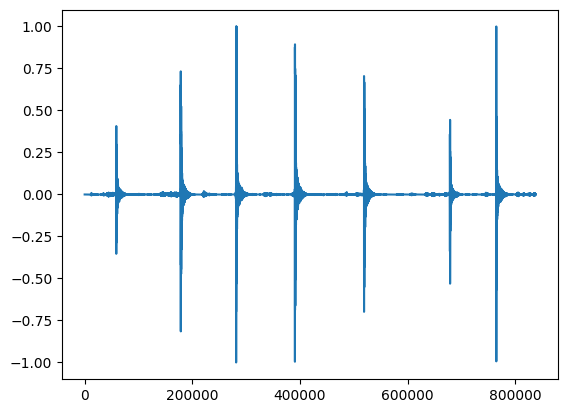

In [4]:
fig, ax = plt.subplots()
ax.plot(audio)

In [5]:
peaks, _ = scipy.signal.find_peaks(audio, height=0.3, distance=0.1 * FS)
print(peaks)

[ 58844 178632 281484 390881 519176 679104 764959]


In [6]:
responses_unclipped = [audio[peak:peak+20000] for peak in peaks]
normalized_responses_unclipped = [resp / resp[0] for resp in responses_unclipped]

In [7]:
WINDOW_SIZE = 1000

def response_length(signal: np.ndarray, plot: bool = False) -> np.ndarray:
    peak = signal[0]
    normalized_signal = signal / peak

    kernel = np.ones(WINDOW_SIZE) / WINDOW_SIZE
    filtered_signal = np.convolve(np.abs(normalized_signal), kernel, mode='same')

    response_cutoff = np.argmax(filtered_signal < 0.05 * np.max(filtered_signal))

    if plot:
        fig, axs = plt.subplots(2)
        axs[0].plot(normalized_signal)
        axs[0].axvline(response_cutoff, linestyle="--", color="r")
        axs[1].plot(filtered_signal)
        axs[1].axvline(response_cutoff, linestyle="--", color="r")

    return response_cutoff

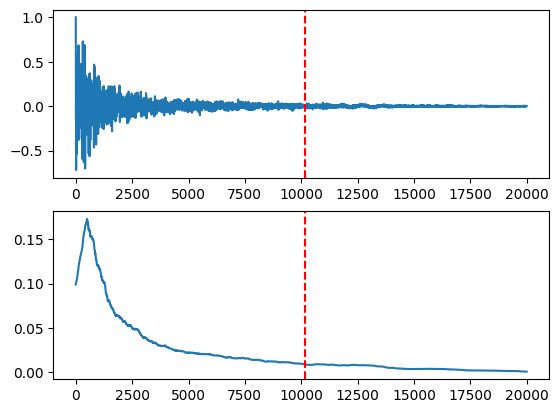

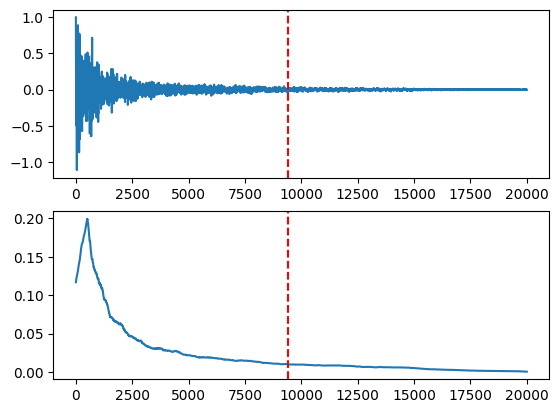

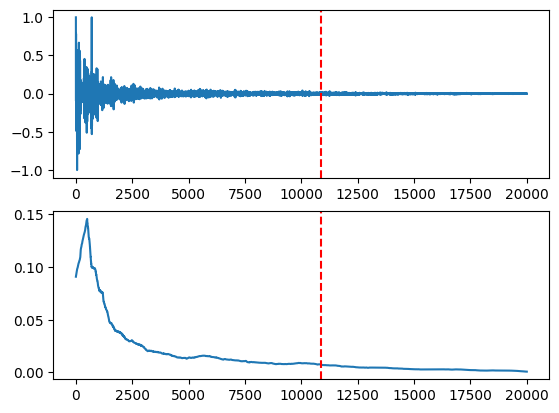

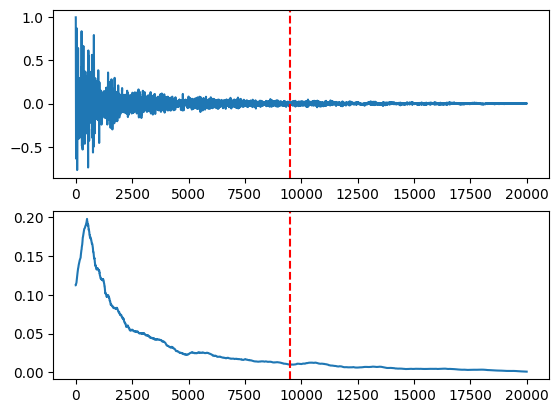

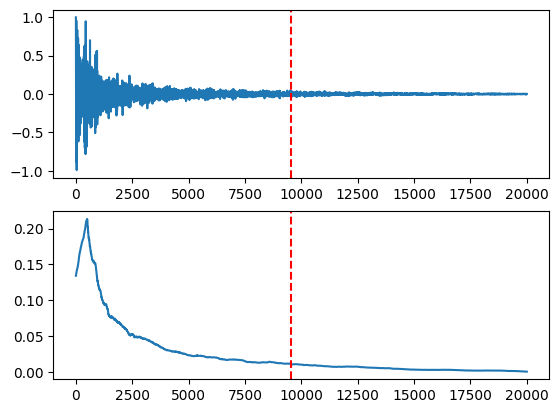

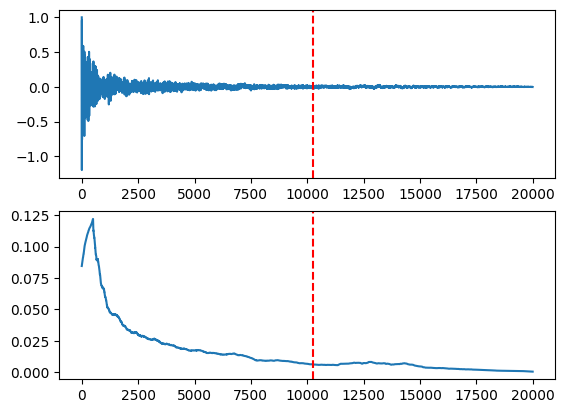

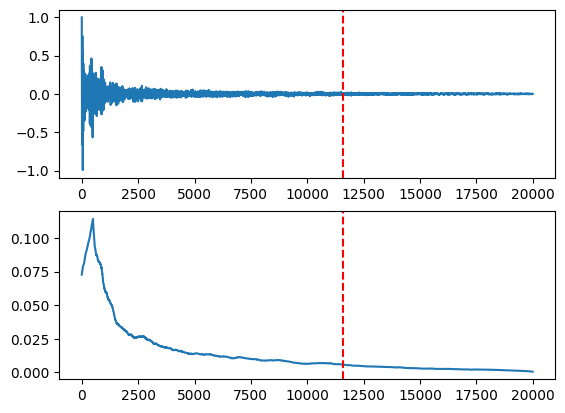

In [8]:
cutoffs = [response_length(resp, plot=True) for resp in normalized_responses_unclipped]

In [9]:
impulse_length = round(np.median(cutoffs))
print(cutoffs)
print(impulse_length)

[np.int64(10158), np.int64(9396), np.int64(10881), np.int64(9492), np.int64(9557), np.int64(10275), np.int64(11604)]
10158


In [10]:
impulse_responses = [resp[:impulse_length] for resp in normalized_responses_unclipped]

In [11]:
def calculate_freq_gain(impulse_response: np.ndarray):
    gains = np.fft.rfft(impulse_response)
    db_gains = 20 * np.log10(np.abs(gains))
    return db_gains

In [12]:
freqs = np.fft.rfftfreq(impulse_length, d=1./FS)
gains = [calculate_freq_gain(resp) for resp in impulse_responses]

In [13]:
avg_gain = np.mean(gains, axis=0)

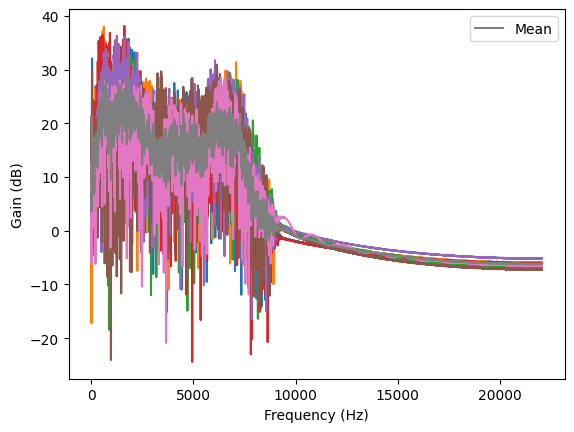

In [14]:
for gain in gains:
    plt.plot(freqs, gain)
plt.plot(freqs, avg_gain, label="Mean")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.legend()